In [ ]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import _filter_positive_future, _add_deltas, split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import cast_feature_dtypes, pull_training_data, pull_prediction_data, pull_projections
from modeling import calculate_productivity_score, split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import batting_stat_cols, pitching_stat_cols, batting_career_cols, pitching_career_cols
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2022
END_YEAR = 2024
PRED_YEAR = (END_YEAR + 1)
AGG_YEARS = 3
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.25
PITCHER_SPLIT = 0.35
BATTER_SPLIT_IF = 0.35
BATTER_SPLIT_OF = 0.3

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
# Pull training data for batters & pitchers
batting_df, pitching_df = pull_training_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_career_cols=batting_career_cols,
    pitching_career_cols=pitching_career_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Additional feature engineering
# Filter out players with negative future fantasy points (will not be fantasy draft eligible regardless)
# Calculate deltas for core stats over the aggregation window
# Calculate player productivity score (how effective are they relative to their age)
# Ensure proper data types for modeling
batting_df = (
    batting_df
    .pipe(_filter_positive_future, target_col="fantasy_points_future")
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=batting_career_cols)
    .pipe(calculate_productivity_score)
    .pipe(cast_feature_dtypes)
)

pitching_df = (
    pitching_df
    .pipe(_filter_positive_future, target_col="fantasy_points_future")
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=pitching_career_cols)
    .pipe(calculate_productivity_score)
    .pipe(cast_feature_dtypes)
)

Loaded existing data files.


# Pulling FantasyPros Projection Data

In [3]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [4]:
display(batting_projections.head())

,first_name,last_name,Team,Positions,projected_fantasy_points
0,shohei,ohtani,LAD,"SP,DH",1765
1,aaron,judge,NYY,"LF,CF,RF,DH",1721
2,bobby,witt,KC,SS,1540
3,juan,soto,NYM,"LF,RF",1643
4,ronald,acuna,ATL,RF,1536


# Defining Baseline Model

## Creating baseline batting predictions

In [59]:
## TODO: Follow methodology used in NFL modeling process to define VORP-scale parameter value
## TODO: Finalize revised relative value methodology
## TODO: Adjust final projection values with methodology from NFL modeling process to use updated relative player value calculations

In [5]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 300.740 | MAE: 236.793 | R^2: 0.568


In [6]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
78,Shohei Ohtani,1635.0,1548.279663,-86.720337,86.720337,2022,27,1483
58,Bo Bichette,1161.0,1423.656982,262.656982,262.656982,2022,24,1418
75,Francisco Lindor,1555.0,1421.627441,-133.372559,133.372559,2022,28,1473
24,Julio Rodriguez,1617.0,1407.279053,-209.720947,209.720947,2022,21,1283
55,Matt Olson,1850.0,1406.717773,-443.282227,443.282227,2022,28,1429
...,...,...,...,...,...,...,...,...
0,Jose Herrera,165.0,252.084229,87.084229,87.084229,2022,25,124
42,Mike Ford,505.0,229.672882,-275.327118,275.327118,2022,29,209
50,Jonathan Davis,192.0,212.037872,20.037872,20.037872,2022,30,150
12,Jose Barrero,246.0,210.935715,-35.064285,35.064285,2022,24,187


# Building Final Models

In [7]:
MAX_DEPTH_CHOICES = [3, 4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(4.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(4.0)),
}

# Batting Predictions

In [8]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=25,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 25/25 [00:09<00:00,  2.59trial/s, best loss: 288.54230530926924]
Best Parameters: {'learning_rate': 0.09342115434548916, 'max_depth': 5, 'subsample': 0.859068073192051, 'colsample_bytree': 0.907111182191811, 'min_child_weight': 7.520606482142205, 'reg_lambda': 1.0836618868218466, 'reg_alpha': 0.0014854099922631788, 'gamma': 0.0012587224567490061}
[Best trial @ val] optimized=rmse | RMSE=288.542 | MAE=228.092 | ASYM=96474.769


In [9]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 41
[Val] RMSE: 288.542 | MAE: 228.092 | R^2: 0.420 | ASYM: 96474.769
[Test] RMSE: 309.332 | MAE: 253.820 | R^2: 0.543 | ASYM: 124091.650


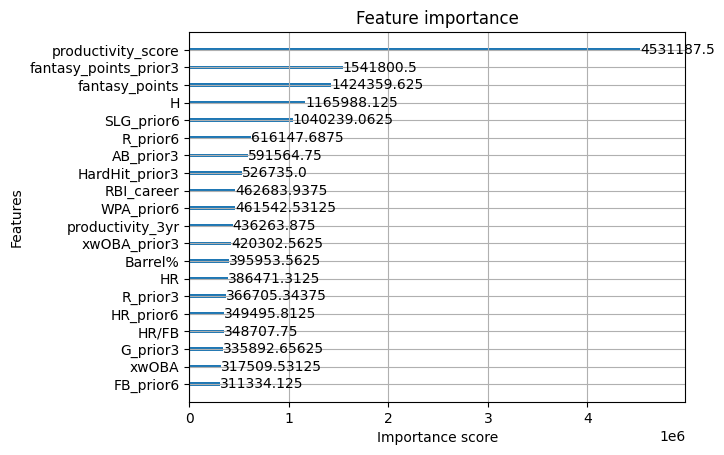

In [10]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=20)
plt.show()

In [11]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
78,Shohei Ohtani,1635.0,1526.373901,-108.626099,108.626099,2022,27,1483
75,Francisco Lindor,1555.0,1475.247803,-79.752197,79.752197,2022,28,1473
62,Bryan Reynolds,1305.0,1408.010132,103.010132,103.010132,2022,27,1202
55,Matt Olson,1850.0,1400.888672,-449.111328,449.111328,2022,28,1429
66,Jose Altuve,985.0,1380.432373,395.432373,395.432373,2022,32,1407
...,...,...,...,...,...,...,...,...
32,Andrew Velazquez,177.0,314.628723,137.628723,137.628723,2022,27,528
12,Jose Barrero,246.0,297.333099,51.333099,51.333099,2022,24,187
1,Jake Marisnick,150.0,281.967743,131.967743,131.967743,2022,31,136
27,Mike Zunino,200.0,278.121979,78.121979,78.121979,2022,31,162


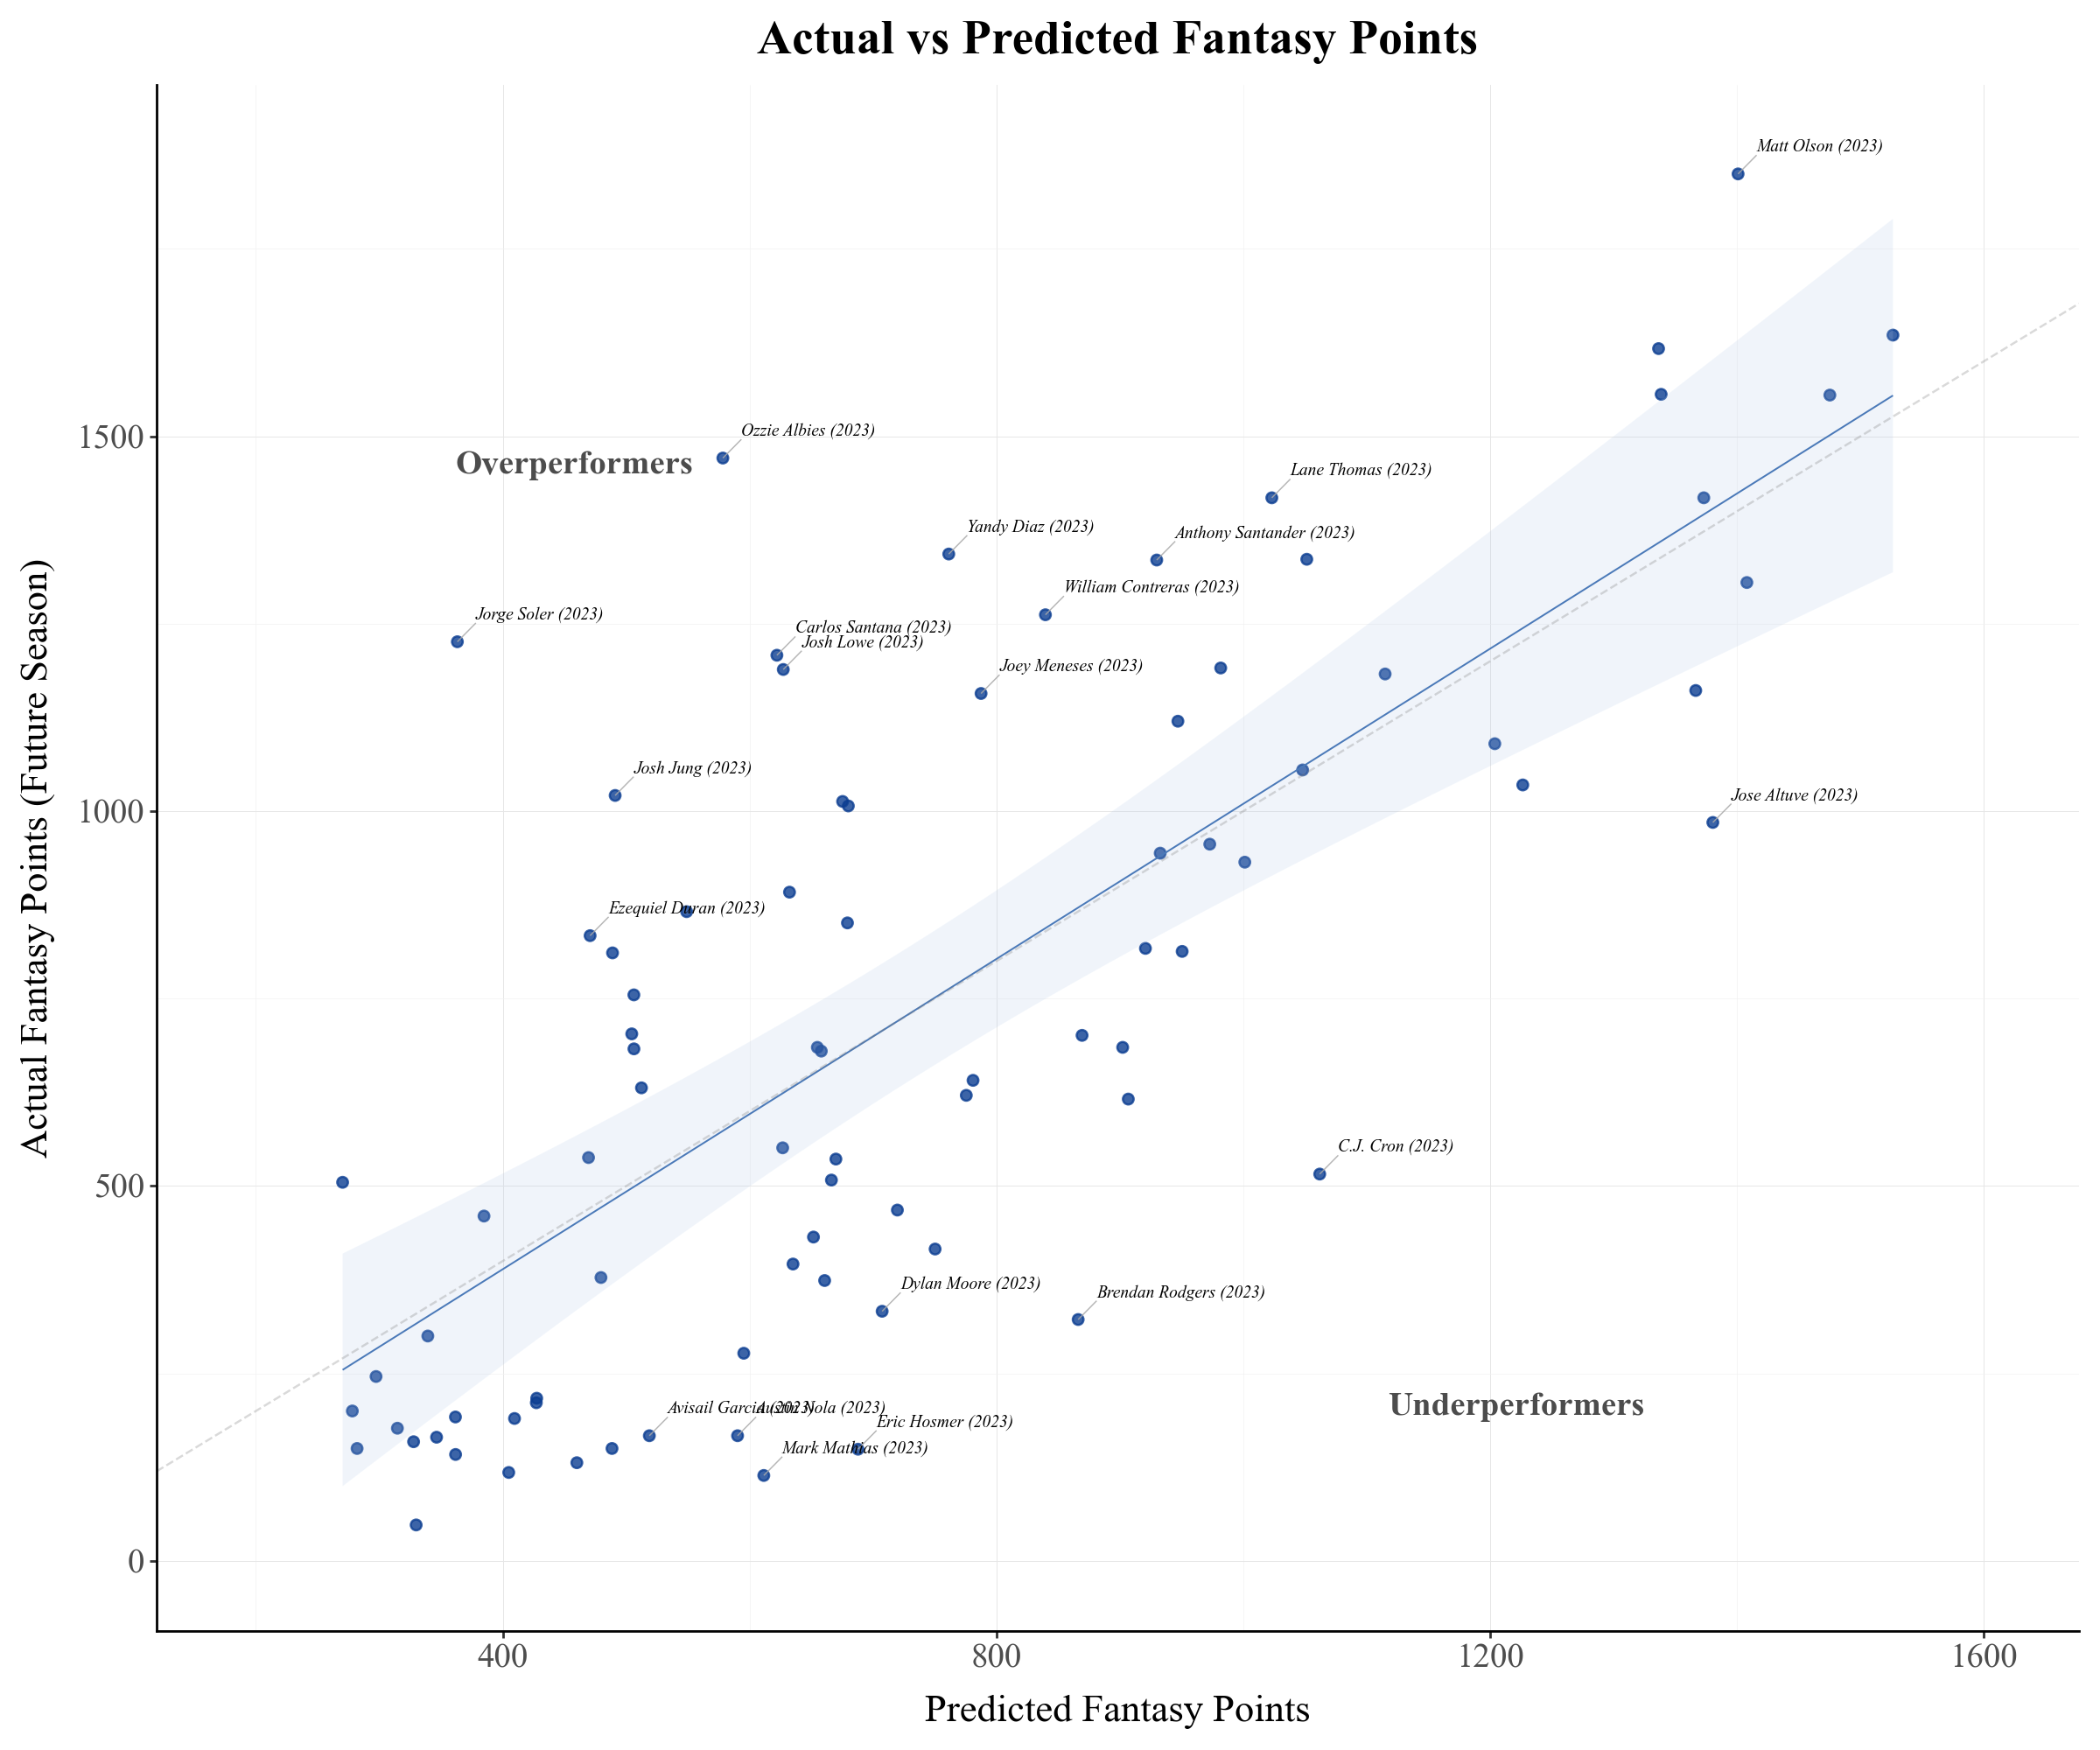

In [12]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

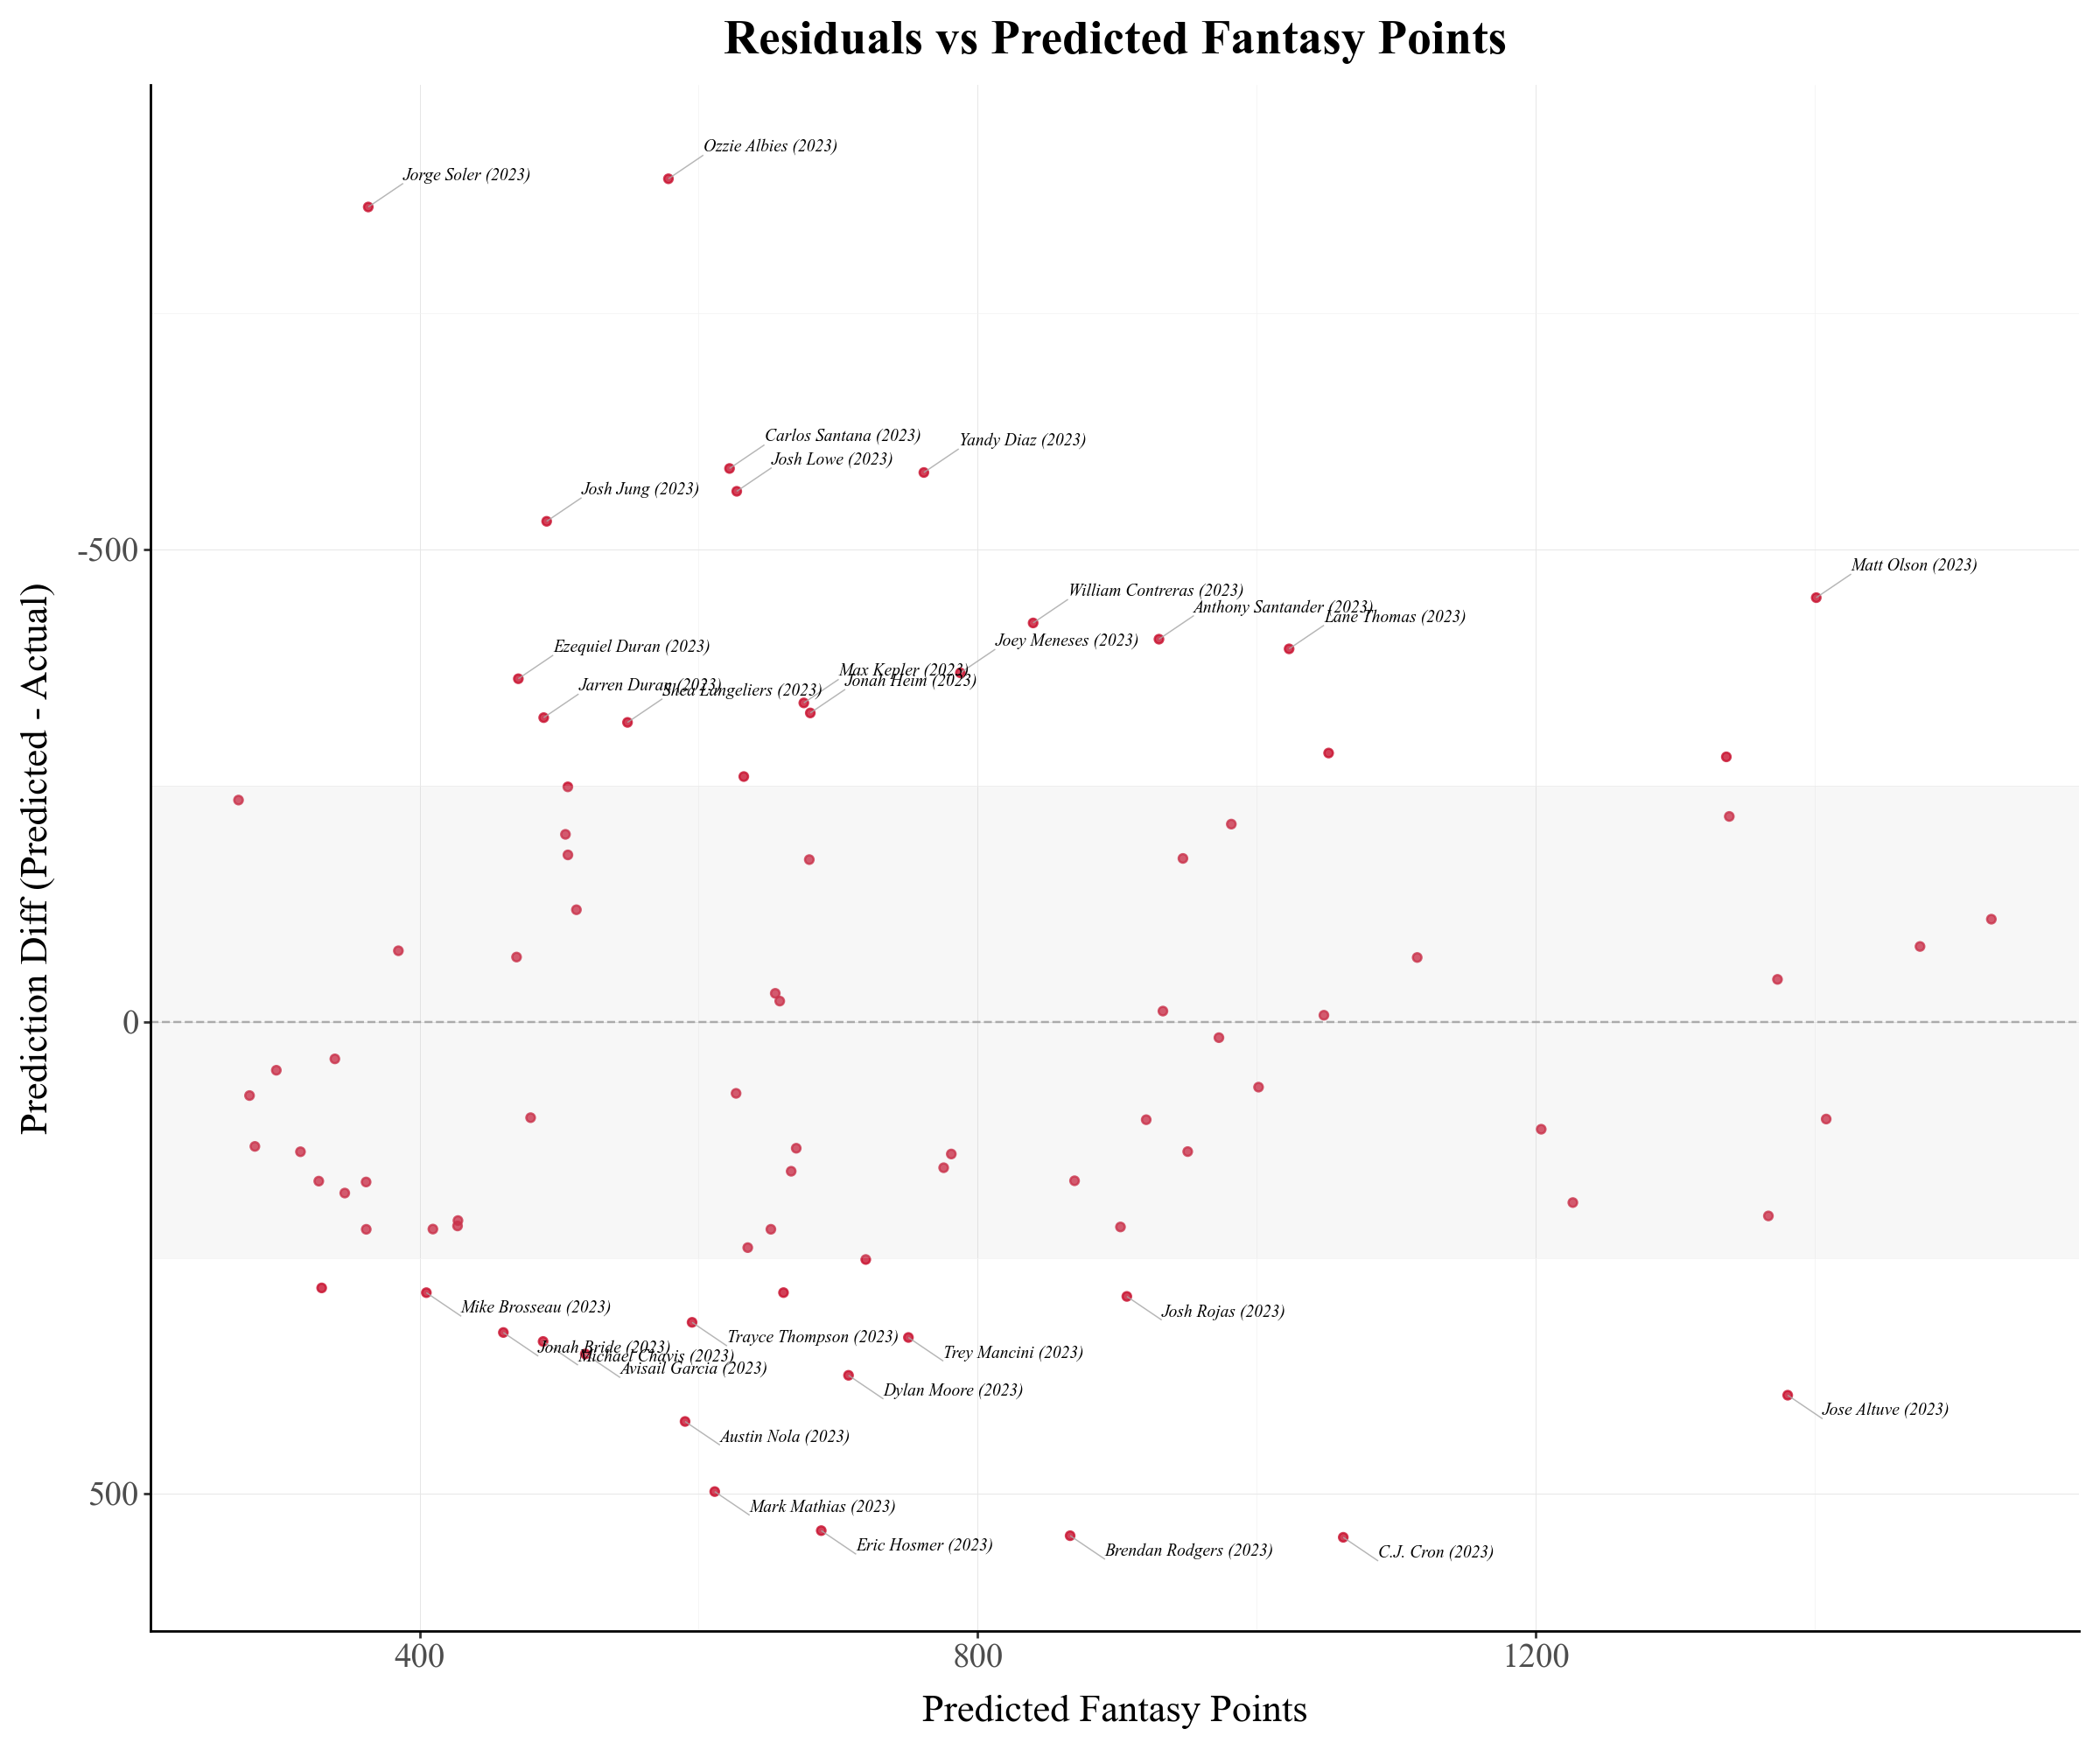

In [13]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

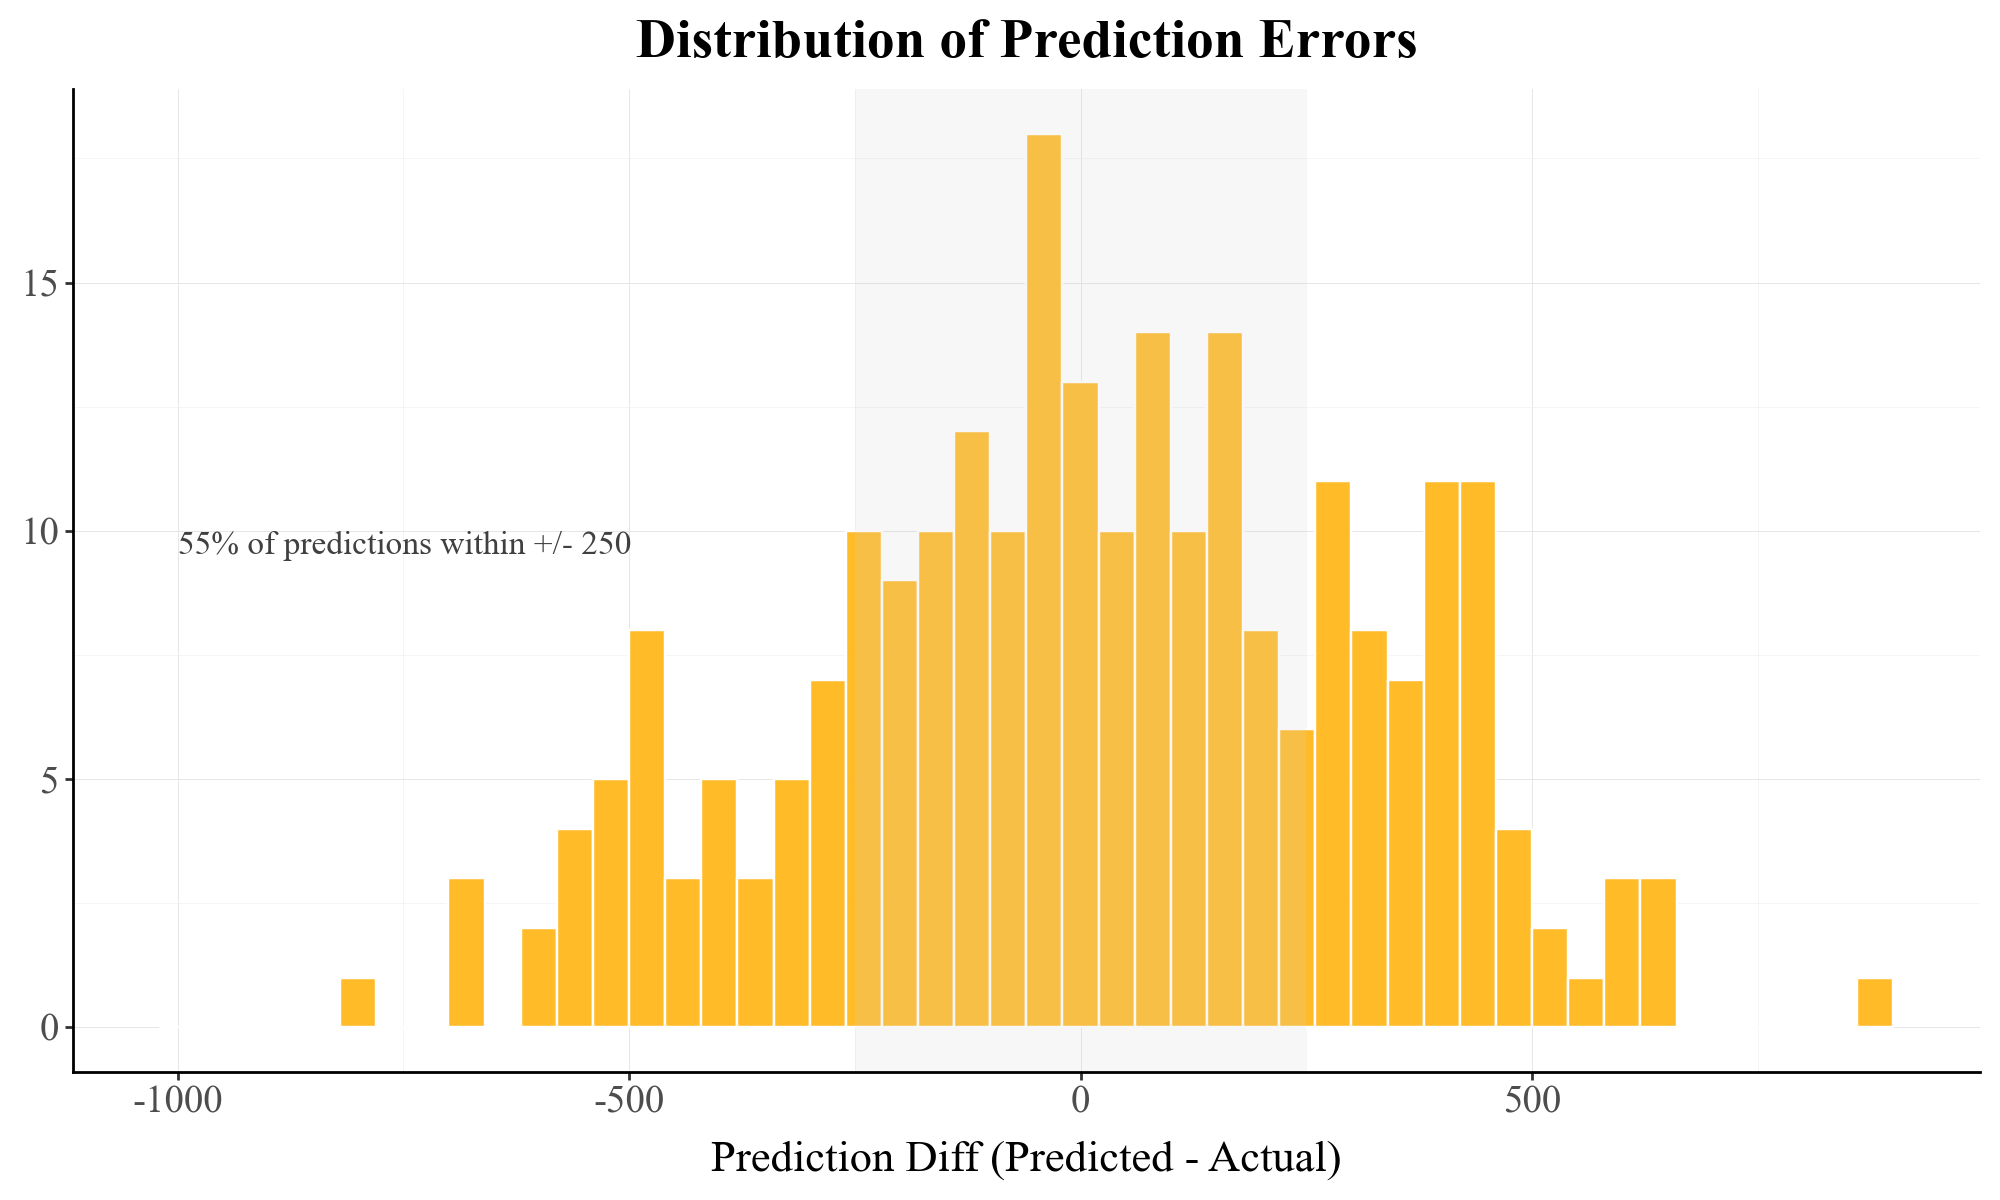

In [14]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=10,      # custom annotation position
)
p3.show()

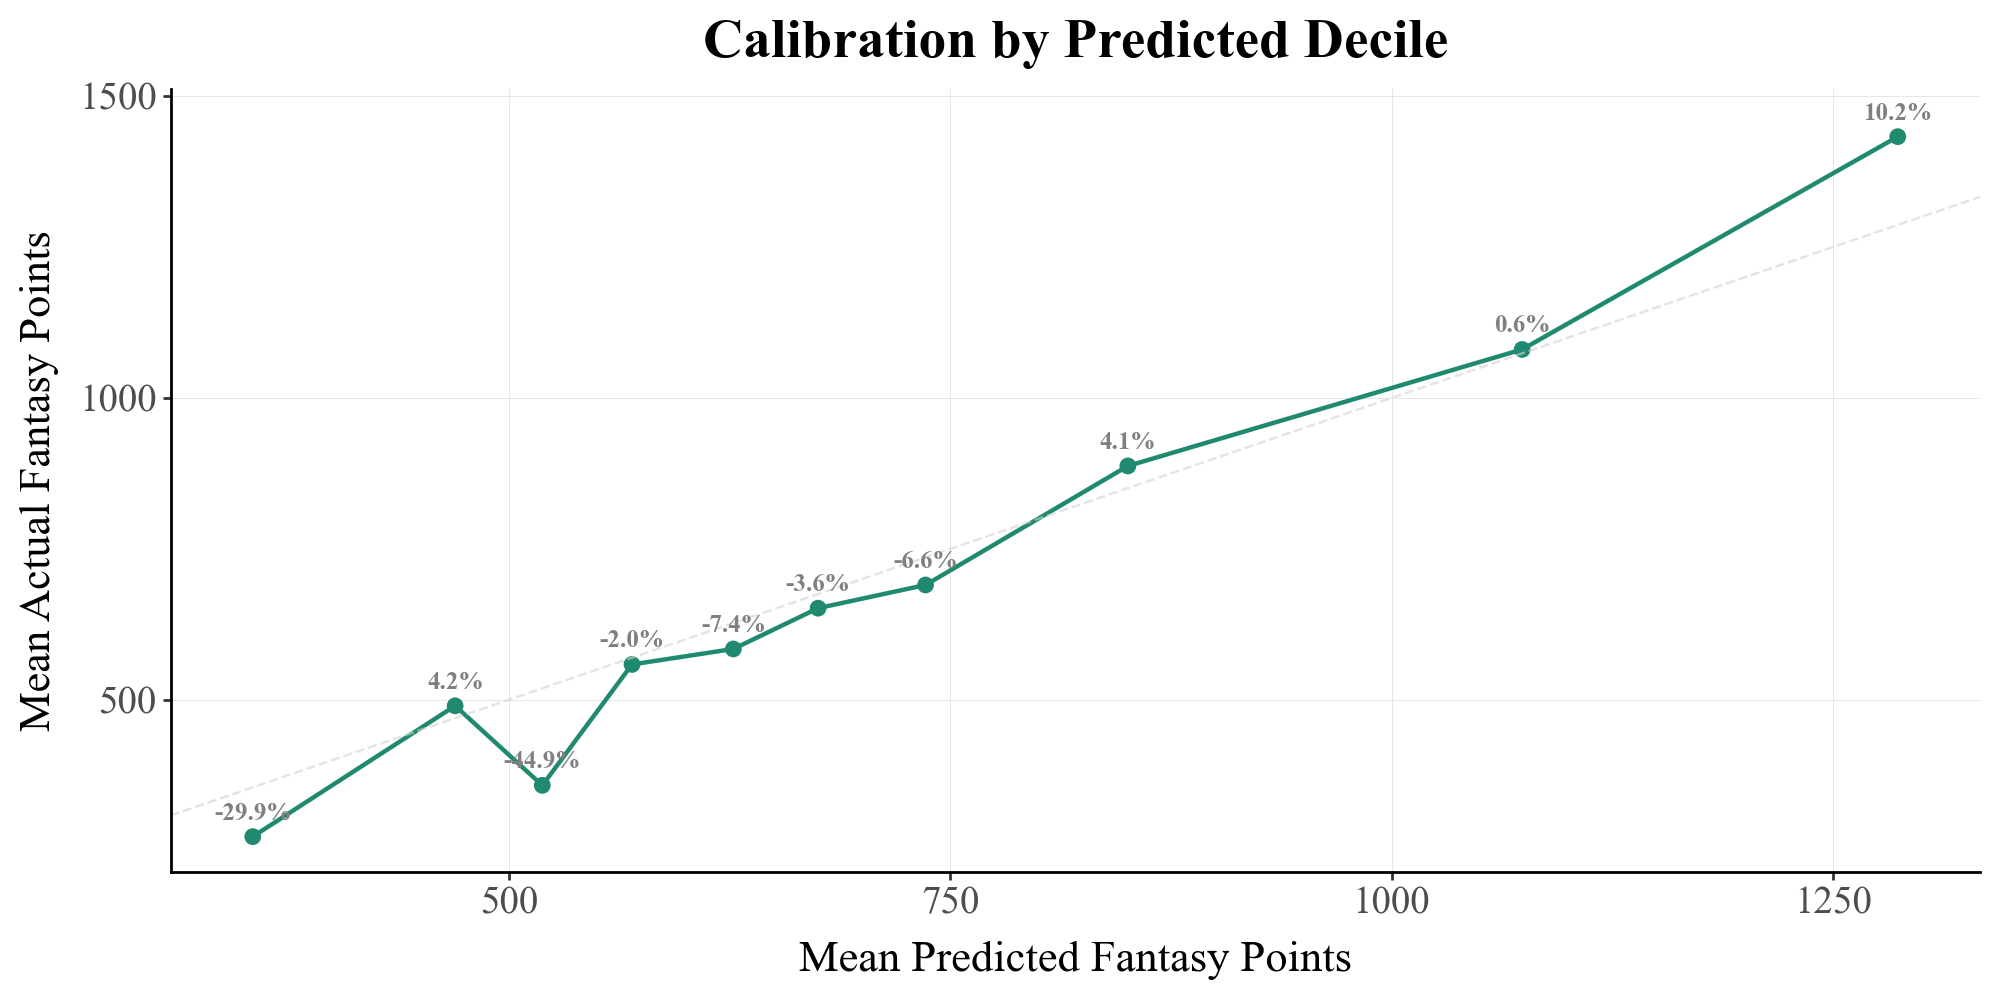

In [15]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating baseline pitching predictions

In [16]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 201.397 | MAE: 156.312 | R^2: 0.417


In [17]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
97,Zac Gallen,802.0,933.920715,131.920715,131.920715,2023,27,1132.0
40,Kevin Gausman,1131.0,913.312683,-217.687317,217.687317,2022,31,1002.6
194,Framber Valdez,939.3,894.067627,-45.232373,45.232373,2023,29,1026.0
84,Luis Castillo,892.3,870.156433,-22.143567,22.143567,2023,30,1099.0
68,Logan Webb,956.6,865.121094,-91.478906,91.478906,2023,26,1051.0
...,...,...,...,...,...,...,...,...
146,Chase Anderson,195.3,166.800293,-28.499707,28.499707,2023,35,299.3
72,Domingo Tapia,72.6,161.288223,88.688223,88.688223,2022,30,39.0
77,Wandy Peralta,357.6,159.341766,-198.258234,198.258234,2024,32,144.3
96,Chasen Shreve,203.6,151.964294,-51.635706,51.635706,2022,31,113.3


# Pitching Predictions

In [18]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=25,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 25/25 [00:16<00:00,  1.52trial/s, best loss: 188.87047982624523]
Best Parameters: {'learning_rate': 0.08259653478536469, 'max_depth': 3, 'subsample': 0.9458896145446555, 'colsample_bytree': 0.8427688091430552, 'min_child_weight': 1.0455622059996459, 'reg_lambda': 10.058705803903257, 'reg_alpha': 0.024734434813658297, 'gamma': 0.00016095774511442959}
[Best trial @ val] optimized=rmse | RMSE=188.870 | MAE=144.043 | ASYM=46381.710


In [19]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 71
[Val] RMSE: 188.870 | MAE: 144.043 | R^2: 0.460 | ASYM: 46381.710
[Test] RMSE: 189.900 | MAE: 148.081 | R^2: 0.481 | ASYM: 46514.084


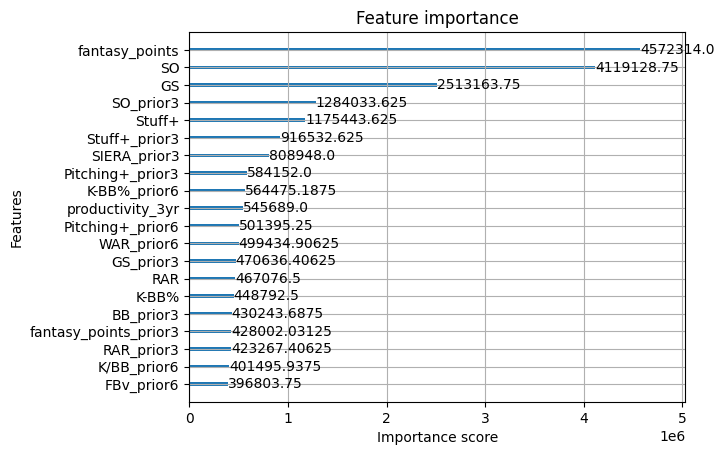

In [20]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=20)
plt.show()

In [21]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
97,Zac Gallen,802.0,907.499390,105.499390,105.499390,2023,27,1132.0
84,Luis Castillo,892.3,893.612732,1.312732,1.312732,2023,30,1099.0
40,Kevin Gausman,1131.0,875.179016,-255.820984,255.820984,2022,31,1002.6
68,Logan Webb,956.6,845.299438,-111.300562,111.300562,2023,26,1051.0
45,Dylan Cease,1090.3,834.430481,-255.869519,255.869519,2023,27,938.0
...,...,...,...,...,...,...,...,...
37,Grant Anderson,93.6,193.034866,99.434866,99.434866,2023,26,145.6
63,Tim Hill,134.3,191.952103,57.652103,57.652103,2022,32,177.0
156,Jake Woodford,99.3,185.731537,86.431537,86.431537,2024,27,90.0
203,Dany Jimenez,113.6,182.692230,69.092230,69.092230,2023,29,105.3


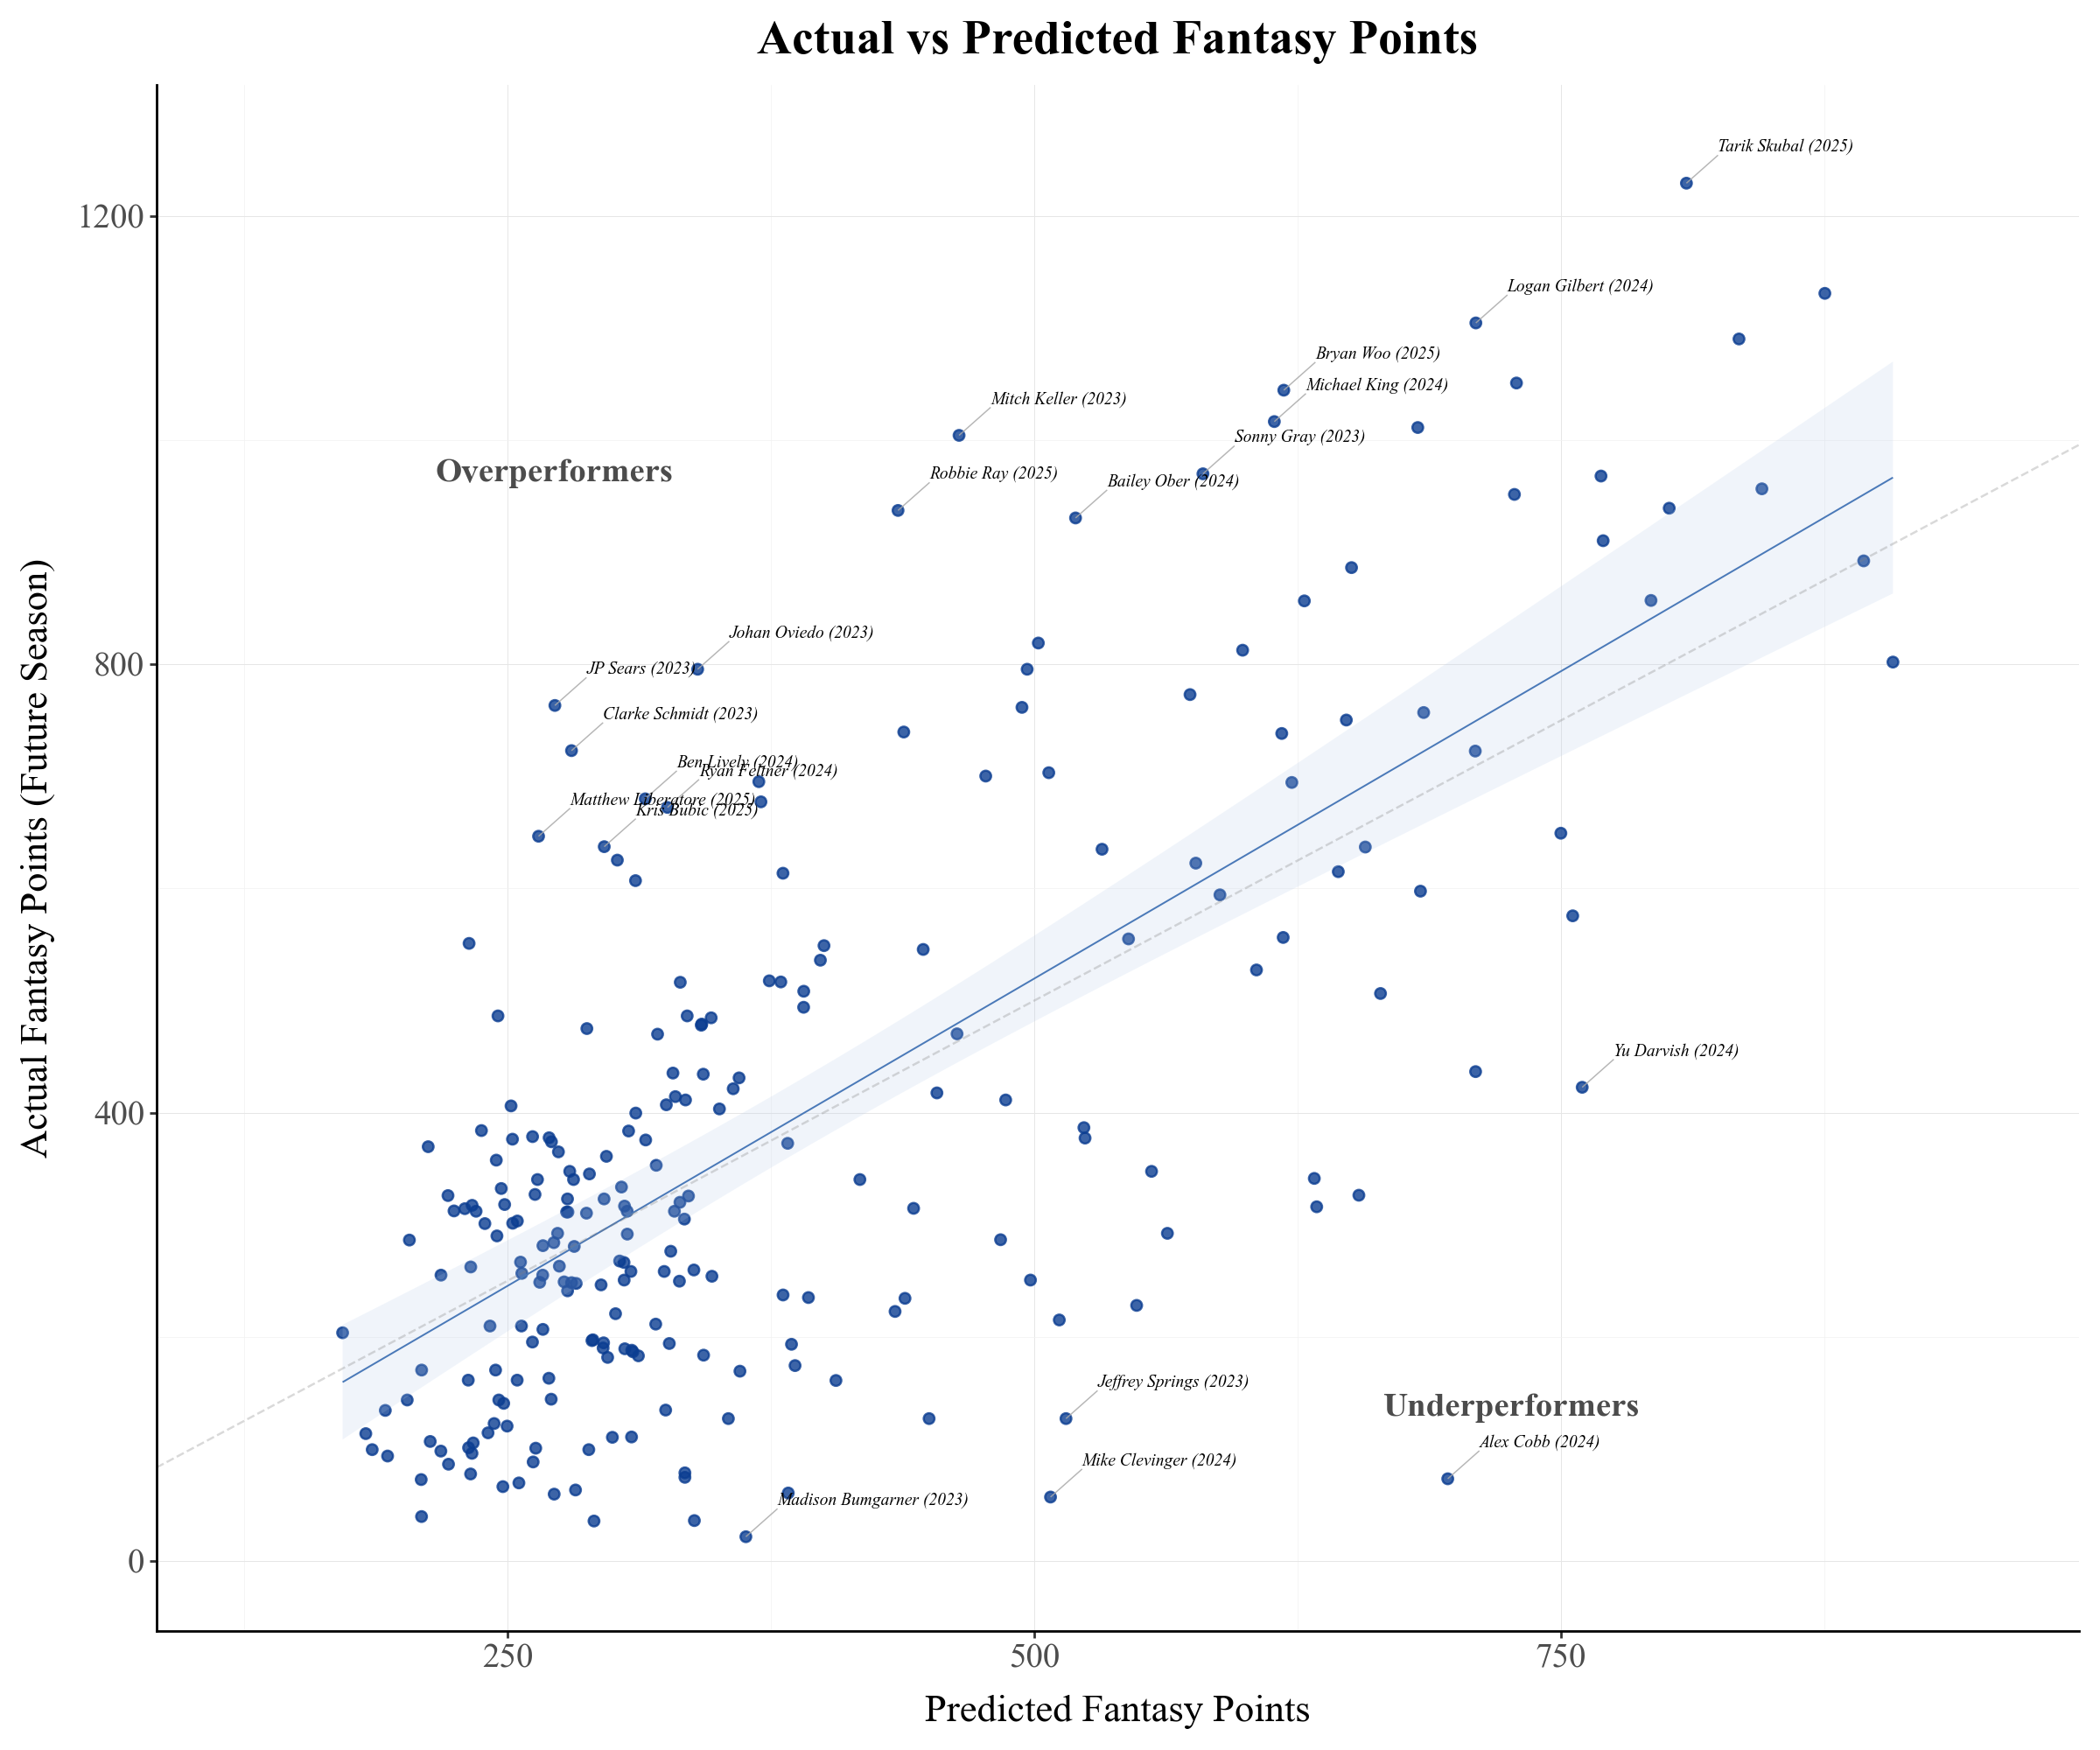

In [22]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

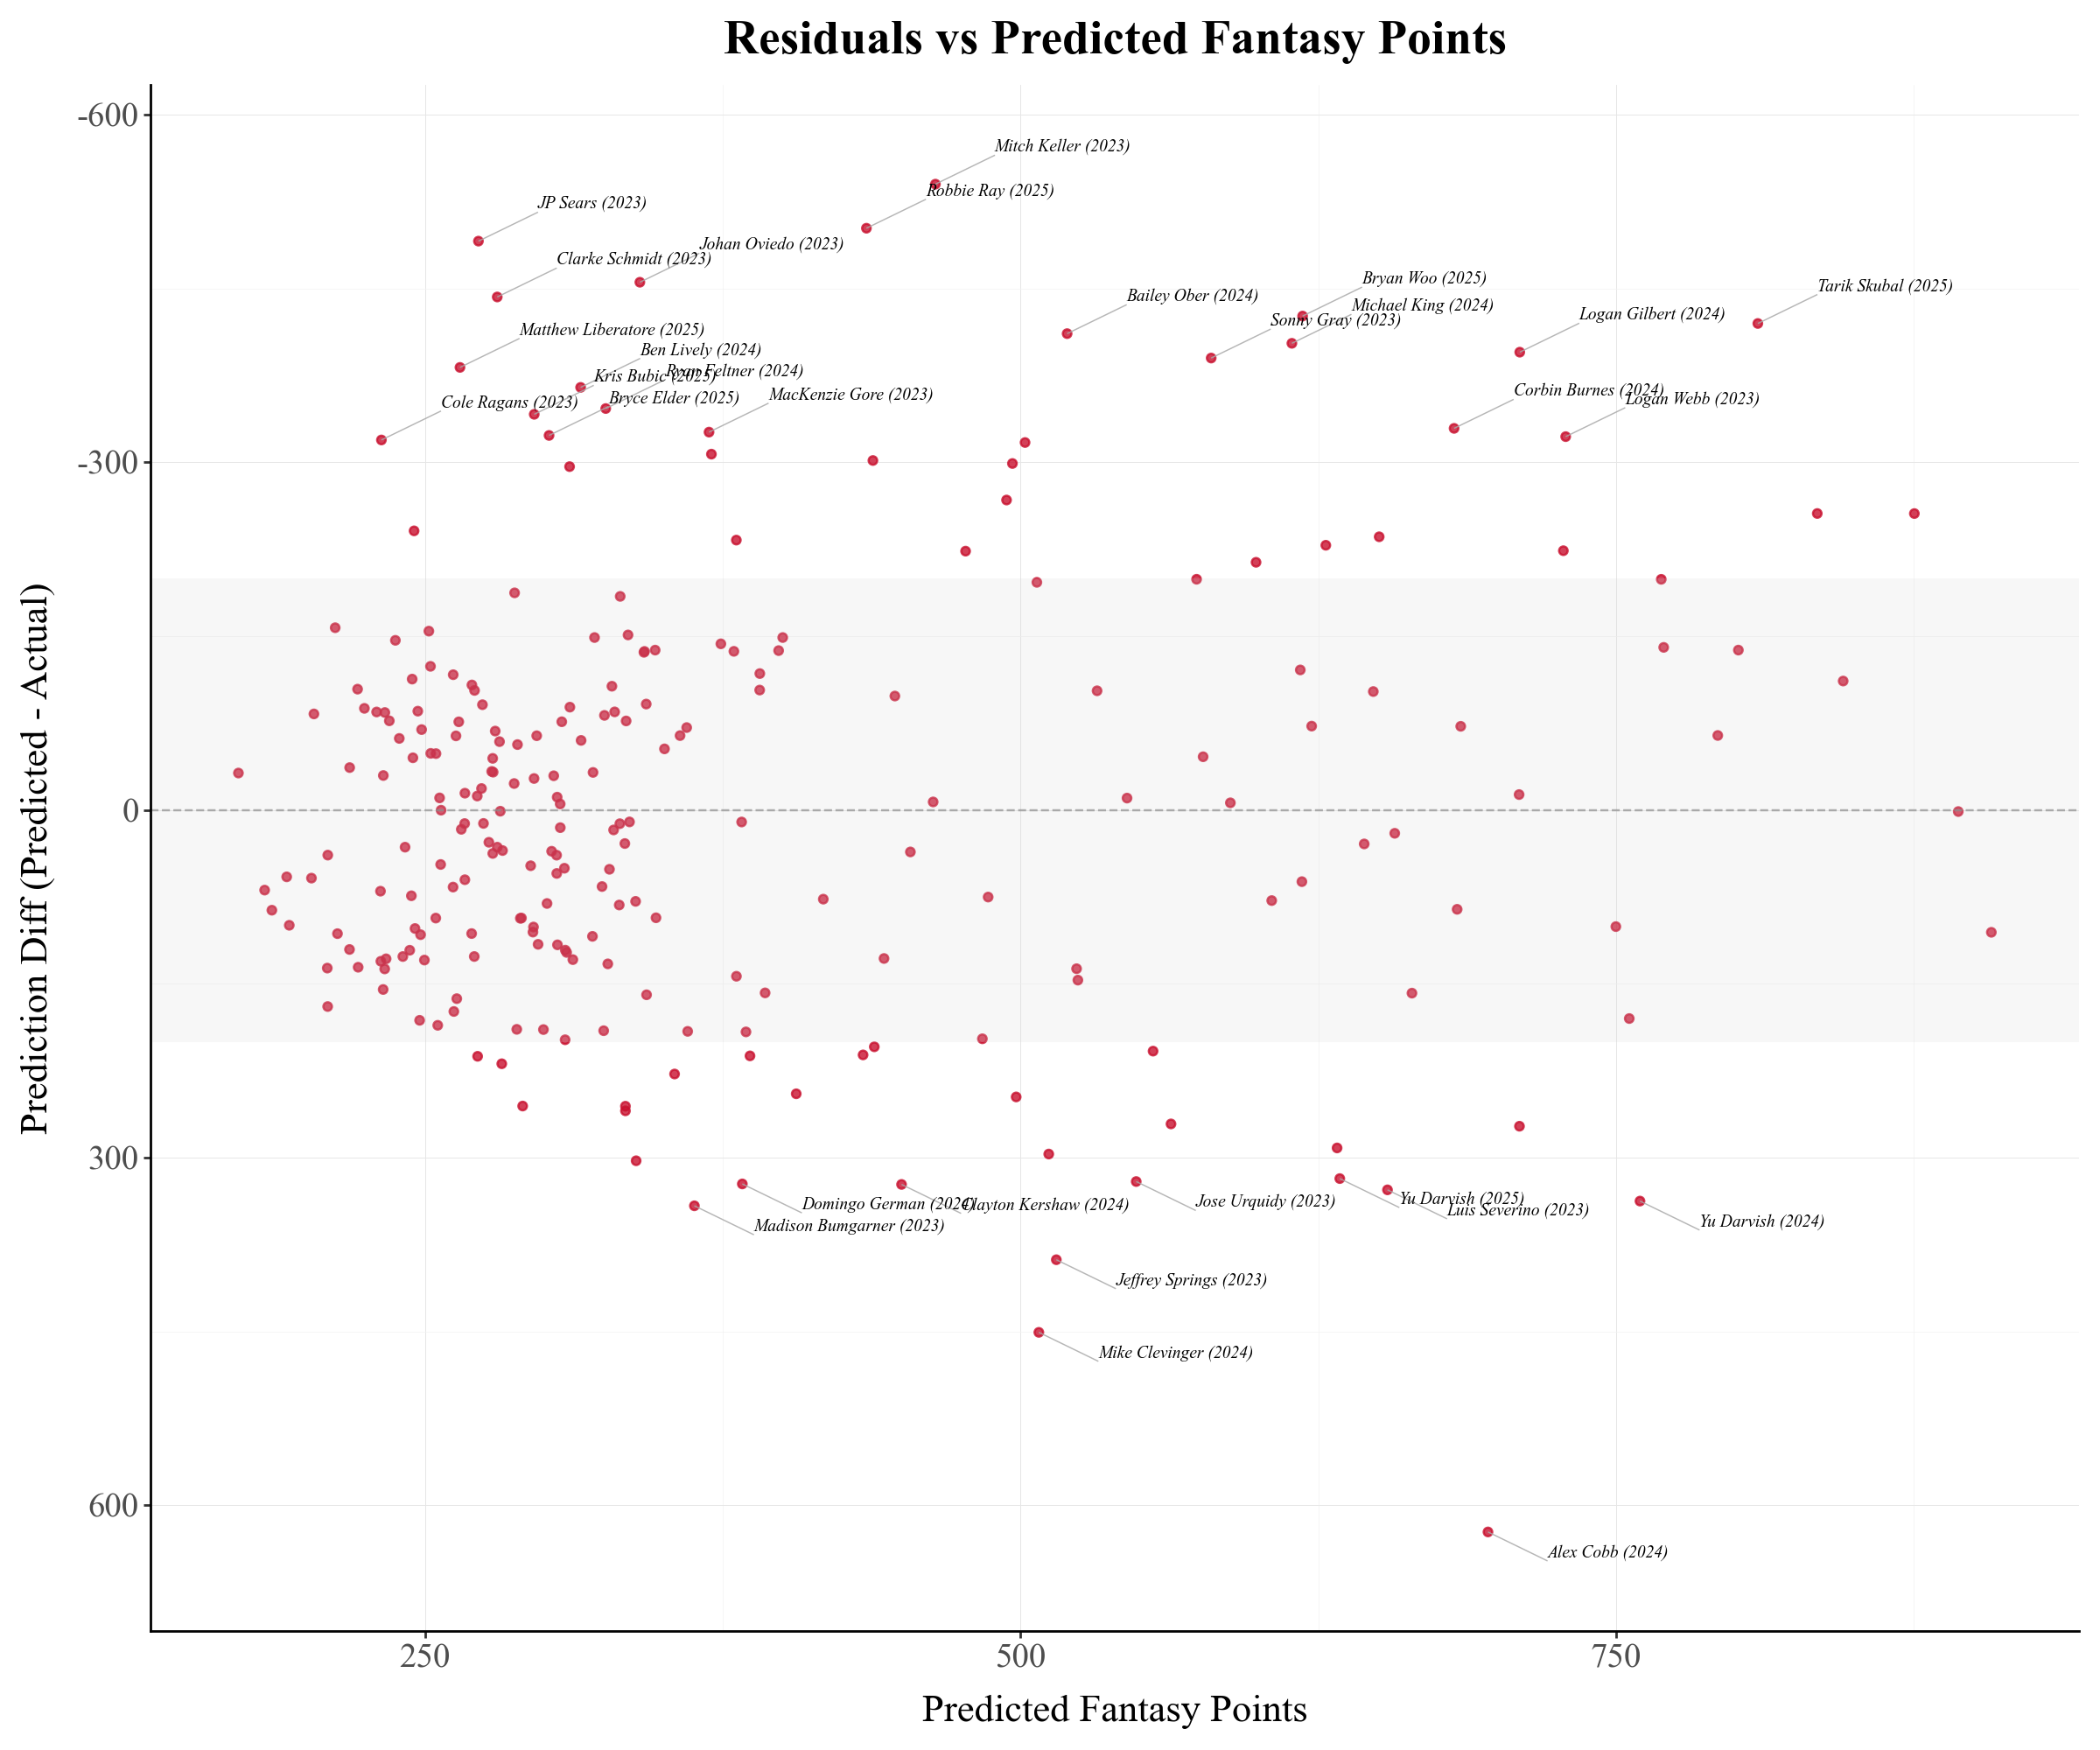

In [23]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

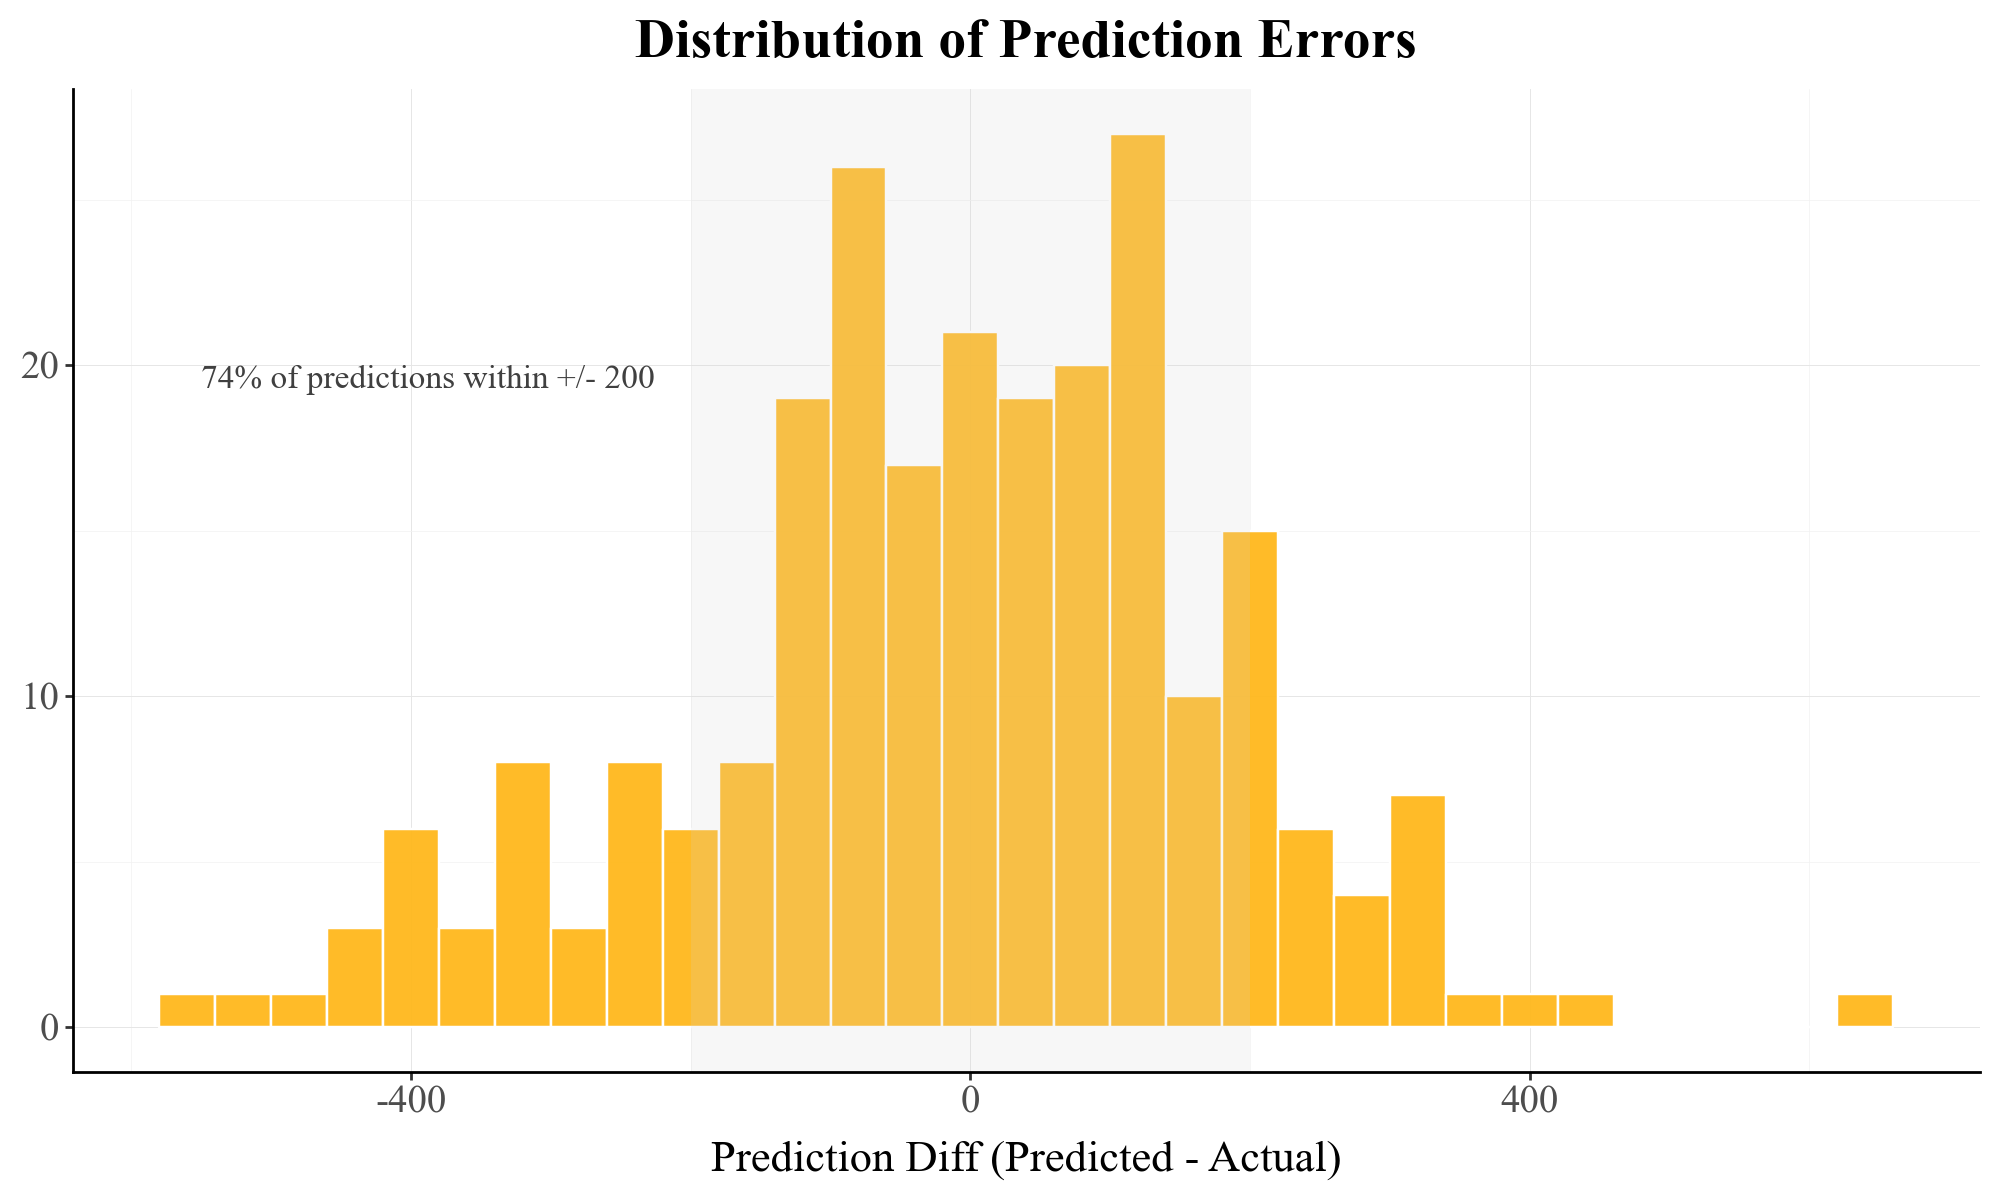

In [24]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=200,
    binwidth=40,
    x_annotate=-550,    # custom annotation position
    y_annotate=20,      # custom annotation position
)
p3.show()

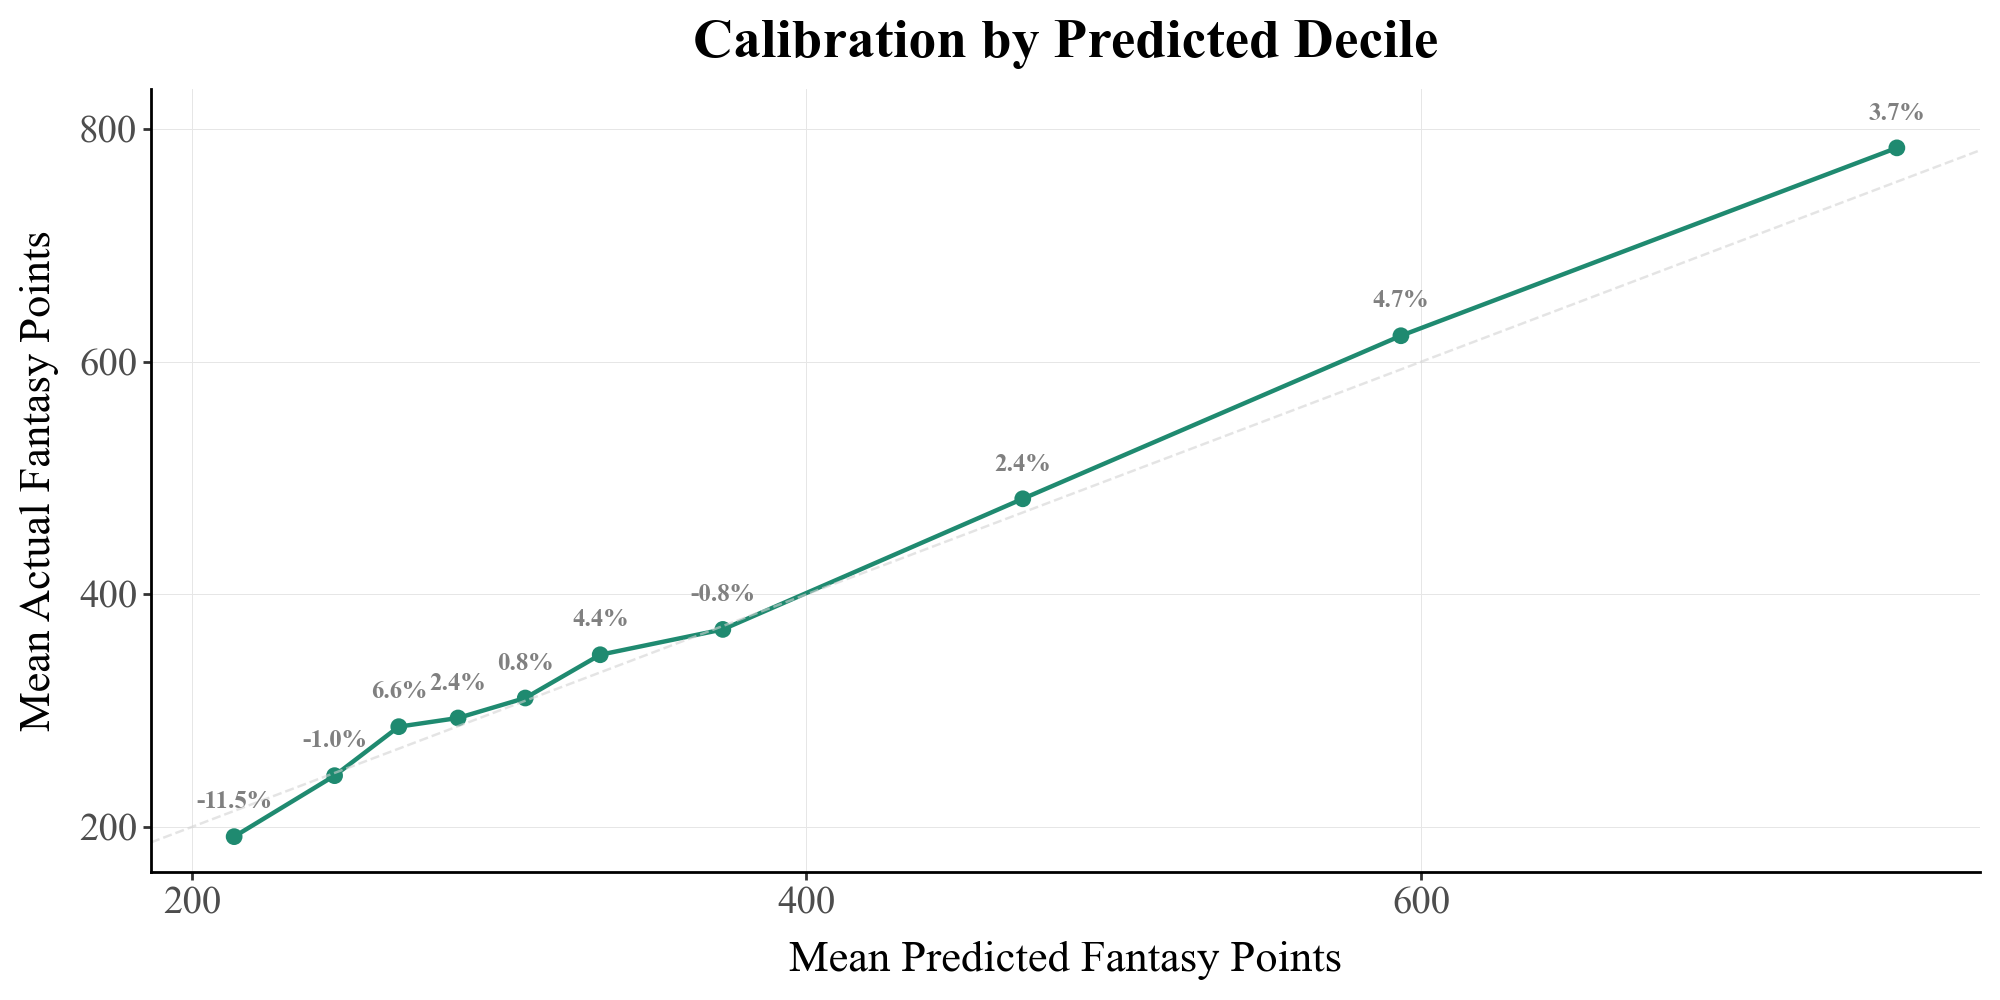

In [25]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [185]:
# import pandas as pd
# from pybaseball import batting_stats, pitching_stats, playerid_reverse_lookup
# from helper import calc_fantasy_points_batting, calc_fantasy_points_pitching, add_suffix_to_columns, save_data, load_training_data
# def validate_covid_impact(season, years):
#     """
#     This function checks if the year 2020 occurred during the specified number of years leading up to the given season.
#     """
#     start_year = season - years
#     end_year = season
#     return 2020 in range(start_year, end_year + 1)

# def player_data(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Pulls player data from the pybaseball API and merges it with the provided DataFrame to obtain player rookie seasons.

#     Parameters:
#     df (pd.DataFrame): The DataFrame to which the player data will be added.

#     Returns:
#     pd.DataFrame: The DataFrame with the player data added.
#     """

#     player_ids = df['IDfg'].unique().tolist()
#     player_ids = playerid_reverse_lookup(player_ids, key_type='fangraphs').filter(items = ['key_fangraphs', 'mlb_played_first'])
#     player_ids = player_ids.rename(columns = {'key_fangraphs': 'IDfg', 'mlb_played_first': 'rookie_year'})
#     df = df.merge(player_ids, on = 'IDfg', how = 'left')
    
#     # Add total years in league to the data for each player for context on eligible playing years
#     df['years_in_league'] = df['Season'] - df['rookie_year']
#     return df

# def pull_prediction_data(prediction_year: int, agg_years: int, batting_stat_cols: list, pitching_stat_cols: list) -> tuple:
#     """
#     Pulls and processes batting and pitching data for the specified years.

#     Parameters:
#     end_year (int): The end year for the data pull.
#     agg_years (int): The number of years to aggregate for prior data.
#     batting_stat_cols (list): List of columns to include in the batting data.
#     pitching_stat_cols (list): List of columns to include in the pitching data.

#     Returns:
#     tuple: A tuple containing two DataFrames, one for batting data and one for pitching data.
#     """
#     # Initialize empty DataFrames
#     batting_df = pd.DataFrame()
#     pitching_df = pd.DataFrame()

#     # Creating start and end years for the aggregated data pull of prior player seasons
#     end_year_prior = prediction_year - 1
#     start_year_prior = end_year_prior - agg_years

#     # Pulling batting stats
#     batting_df_current = (
#         batting_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 50,
#                         split_seasons = True)
#                         .filter(items = batting_stat_cols)
#     )
#     calc_fantasy_points_batting(batting_df_current, 'fantasy_points')

#     batting_df_prior = (
#         batting_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 50,
#                         split_seasons = False)
#                         .filter(items = batting_stat_cols)
#     )
#     batting_df_prior = batting_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_batting(batting_df_prior, 'fantasy_points_prior')
#     batting_df_prior = add_suffix_to_columns(batting_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining batting features into single dataframe and replace NaN values with 0
#     batting_df_current = (batting_df_current.merge(batting_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Pulling pitching stats
#     pitching_df_current = (
#         pitching_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 20,
#                         split_seasons = True)
#                         .filter(items = pitching_stat_cols)
#     )
#     calc_fantasy_points_pitching(pitching_df_current, 'fantasy_points')

#     pitching_df_prior = (
#         pitching_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 20,
#                         split_seasons = False)
#                         .filter(items = pitching_stat_cols)
#     )
#     pitching_df_prior = pitching_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_pitching(pitching_df_prior, 'fantasy_points_prior')
#     pitching_df_prior = add_suffix_to_columns(pitching_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining pitching features into single dataframe & replace NaN values with 0
#     pitching_df_current = (pitching_df_current.merge(pitching_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Append the results to the main DataFrames
#     batting_df = pd.concat([batting_df, batting_df_current], ignore_index=True)
#     pitching_df = pd.concat([pitching_df, pitching_df_current], ignore_index=True)

#     # Add a column to indicate if the season is during the COVID-19 pandemic
#     batting_df['covid_season'] = batting_df['Season'] == 2020
#     pitching_df['covid_season'] = pitching_df['Season'] == 2020

#     # Add a column to indicate if the prior seasons were during the COVID-19 pandemic
#     batting_df['covid_impact'] = batting_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))
#     pitching_df['covid_impact'] = pitching_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))

#     # Add player rookie seasons onto the data, helps with modeling new players vs veterans
#     batting_df = player_data(batting_df)
#     pitching_df = player_data(pitching_df)

#     # Replacing NaN values with 0
#     batting_df.fillna(0, inplace=True)
#     pitching_df.fillna(0, inplace=True)

#     return batting_df, pitching_df

In [ ]:
# Pull prediction data for batters & pitchers
batting_new, pitching_new = pull_prediction_data(year = PRED_YEAR,
                                    agg_years=AGG_YEARS, 
                                    batting_stat_cols=batting_stat_cols, 
                                    pitching_stat_cols=pitching_stat_cols,
                                    batting_career_cols=batting_career_cols,
                                    pitching_career_cols=pitching_career_cols,
                                    career_window_years=10)

# Additional feature engineering
# Calculate deltas for core stats over the aggregation window
# Calculate player productivity score (how effective are they relative to their age)
batting_new = (
    batting_new
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=batting_career_cols)
    .pipe(calculate_productivity_score)
    .pipe(cast_feature_dtypes)
)

pitching_new = (
    pitching_new
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=pitching_career_cols)
    .pipe(calculate_productivity_score)
    .pipe(cast_feature_dtypes)
)

Pulling data for year: 2025
Gathering player lookup table. This may take a moment.
Data saved successfully.
Data pull complete.


In [27]:
batting_predictions = batting_model.predict(batting_new.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_new.drop(columns=['IDfg', 'Name']))

In [28]:
batting_new['fantasy_points_pred'] = batting_predictions
pitching_new['fantasy_points_pred'] = pitching_predictions

batting_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [31]:
display(batting_new)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred
373,25878,2025,Corbin Carroll,24,143,564,146,66,32,17,...,2019,16,1,6.0,11-50,17.000000,2.722222,0.0,2.722222,1474.737915
203,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,...,0,0,0,0.0,NaN,29.333333,2.147778,0.0,2.147778,1467.434204
366,25764,2025,Bobby Witt Jr.,25,157,623,184,108,47,6,...,2019,2,1,6.0,top10,-88.666667,2.529600,0.0,2.529600,1435.226196
151,18345,2025,Kyle Tucker,28,136,500,133,82,25,4,...,2015,5,1,10.0,top10,72.666667,1.720663,0.0,1.720663,1409.316650
200,19709,2025,Fernando Tatis Jr.,26,155,594,159,105,27,2,...,0,0,0,0.0,NaN,254.333333,2.248521,0.0,2.248521,1396.338013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,19262,2025,Garrett Hampson,30,62,77,11,9,2,0,...,2013,796,1,12.0,200+,-175.333333,0.137778,0.0,0.137778,269.885406
204,19802,2025,Jhonny Pereda,29,30,69,17,11,6,0,...,0,0,0,0.0,NaN,58.666667,0.129608,0.0,0.129608,268.998108
83,15172,2025,Tim Anderson,32,31,83,17,14,3,0,...,2013,17,1,12.0,11-50,-255.000000,0.101562,0.0,0.101562,257.241211
352,25040,2025,Vinny Capra,28,47,96,12,9,2,0,...,2018,596,1,7.0,200+,56.000000,0.128827,0.0,0.128827,252.587128


In [30]:
display(pitching_new)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred
76,13743,2025,Max Fried,31,32,32,3110,1974,19,4.8,...,2012,7.0,1,13.0,top10,262.866667,1.104370,0.0,1.104370,954.977661
248,19959,2025,Jesus Luzardo,27,32,32,3015,1955,15,5.3,...,2016,94.0,1,9.0,51-100,262.933333,1.416461,0.0,1.416461,954.878784
186,17995,2025,Logan Webb,28,34,34,3282,2165,15,5.5,...,2014,118.0,1,11.0,101-200,94.800000,1.461735,0.0,1.461735,913.823730
85,14107,2025,Kevin Gausman,34,32,32,3030,2042,10,4.1,...,2010,202.0,1,15.0,200+,-23.000000,0.834775,0.0,0.834775,863.447937
279,20778,2025,Cristopher Sanchez,28,32,32,2897,1941,13,6.4,...,0,0.0,0,0.0,NaN,311.000000,1.452806,0.0,1.452806,840.919800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,19924,2025,Bryan Hudson,28,16,0,318,184,0,-0.1,...,2015,82.0,1,10.0,51-100,-79.000000,0.099490,0.0,0.099490,159.876740
25,10315,2025,Michael Tonkin,35,21,0,397,251,2,-0.1,...,2008,906.0,1,17.0,200+,-200.766667,0.081633,0.0,0.081633,158.359451
70,13528,2025,Matt Bowman,34,20,0,447,284,0,0.0,...,2012,410.0,1,13.0,200+,5.833333,0.065398,0.0,0.065398,153.456558
3,3237,2025,T.J. McFarland,36,27,0,272,175,0,-0.1,...,2007,137.0,1,18.0,101-200,-57.733333,0.023611,0.0,0.023611,145.780914


In [32]:
batting_new = split_name(batting_new, 'Name')
pitching_new = split_name(pitching_new, 'Name')

In [33]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_new, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
448,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,-80.666667,0.741349,0.0,0.741349,790.985901,max,muncy,LAD,3B,899.0
449,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,-80.666667,0.741349,0.0,0.741349,790.985901,max,muncy,ATH,"2B,3B,SS",649.0
450,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,226.000000,0.700413,0.0,0.700413,645.262817,max,muncy,LAD,3B,899.0
451,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,226.000000,0.700413,0.0,0.700413,645.262817,max,muncy,ATH,"2B,3B,SS",649.0


In [34]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a.j.,vukovich,ARI,"3B,LF,CF",64.0
1,15640.0,2025.0,Aaron Judge,33.0,152.0,541.0,179.0,94.0,30.0,2.0,...,220.000000,1.791552,0.0,1.791552,1290.090210,aaron,judge,NYY,"LF,CF,RF,DH",1721.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,abimelec,ortiz,TEX,1B,104.0
3,19844.0,2025.0,Abraham Toro,28.0,77.0,259.0,62.0,42.0,13.0,0.0,...,99.666667,0.589286,0.0,0.589286,553.223328,abraham,toro,NaN,NaN,NaN
4,27962.0,2025.0,Adael Amador,22.0,41.0,113.0,20.0,12.0,7.0,0.0,...,95.333333,0.326446,0.0,0.326446,484.002655,adael,amador,COL,2B,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,31562.0,2025.0,Zach Dezenzo,25.0,34.0,98.0,24.0,16.0,6.0,0.0,...,96.666667,0.312000,0.0,0.312000,440.134857,zach,dezenzo,HOU,"1B,LF,RF",173.0
683,19392.0,2025.0,Zach McKinstry,30.0,144.0,452.0,117.0,71.0,23.0,11.0,...,216.333333,1.142222,0.0,1.142222,742.542236,zach,mckinstry,DET,"3B,SS,LF,RF",727.0
684,31347.0,2025.0,Zach Neto,24.0,128.0,502.0,129.0,73.0,29.0,1.0,...,185.000000,2.072917,0.0,2.072917,1261.463379,zach,neto,LAA,SS,1304.0
685,29766.0,2025.0,Zack Gelof,25.0,30.0,92.0,16.0,11.0,3.0,0.0,...,-448.666667,0.214400,0.0,0.214400,333.476715,zack,gelof,ATH,2B,223.0


In [35]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_new, pitching_projections)

No duplicate rows found.


In [36]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,31764.0,2025.0,A.J. Blubaugh,24.0,11.0,3.0,508.0,316.0,3.0,0.1,...,132.000000,0.343750,0.0,0.343750,388.220978,a.j.,blubaugh,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a.j.,causey,KC,P,83.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a.j.,minter,NYM,RP,294.3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a.j.,puk,ARI,RP,159.1
4,23550.0,2025.0,Aaron Ashby,27.0,43.0,1.0,1033.0,645.0,5.0,1.2,...,214.600000,0.553635,0.0,0.553635,413.311462,aaron,ashby,MIL,RP,300.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,20349.0,2025.0,Zack Kelly,30.0,28.0,0.0,583.0,383.0,1.0,0.4,...,-6.466667,0.179222,0.0,0.179222,227.325287,zack,kelly,BOS,"SP,RP",241.5
897,15823.0,2025.0,Zack Littell,29.0,32.0,32.0,2789.0,1868.0,10.0,1.5,...,131.600000,0.905589,0.0,0.905589,461.279907,zack,littell,NaN,SP,709.4
898,10310.0,2025.0,Zack Wheeler,35.0,24.0,24.0,2394.0,1549.0,10.0,4.0,...,-110.600000,0.773551,0.0,0.773551,717.761475,zack,wheeler,PHI,SP,723.9
899,25703.0,2025.0,Zak Kent,27.0,12.0,0.0,308.0,187.0,1.0,0.1,...,51.733333,0.106447,0.0,0.106447,170.874527,zak,kent,STL,"SP,RP",172.6


In [37]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [38]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [39]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [199]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [40]:
# Display the DataFrame to verify the changes
display(batting_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,NaN,A.j. Vukovich,NaN,ARI,3B,NaN,64.0
1,15640.0,Aaron Judge,33.0,NYY,OF,1290.090210,1721.0
2,NaN,Abimelec Ortiz,NaN,TEX,1B,NaN,104.0
3,19844.0,Abraham Toro,28.0,NaN,DH,553.223328,NaN
4,27962.0,Adael Amador,22.0,COL,2B,484.002655,650.0
...,...,...,...,...,...,...,...
682,31562.0,Zach Dezenzo,25.0,HOU,1B,440.134857,173.0
683,19392.0,Zach McKinstry,30.0,DET,3B,742.542236,727.0
684,31347.0,Zach Neto,24.0,LAA,SS,1261.463379,1304.0
685,29766.0,Zack Gelof,25.0,ATH,2B,333.476715,223.0


In [41]:
# Display the DataFrame to verify the changes
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,31764.0,A.J. Blubaugh,24.0,NaN,SP,388.220978,NaN
1,NaN,A.j. Causey,NaN,KC,P,NaN,83.0
2,NaN,A.j. Minter,NaN,NYM,RP,NaN,294.3
3,NaN,A.j. Puk,NaN,ARI,RP,NaN,159.1
4,23550.0,Aaron Ashby,27.0,MIL,RP,413.311462,300.6
...,...,...,...,...,...,...,...
896,20349.0,Zack Kelly,30.0,BOS,SP,227.325287,241.5
897,15823.0,Zack Littell,29.0,NaN,SP,461.279907,709.4
898,10310.0,Zack Wheeler,35.0,PHI,SP,717.761475,723.9
899,25703.0,Zak Kent,27.0,STL,SP,170.874527,172.6


# Finalizing Predictions & Creating Relative Positional Value Scores

In [42]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [43]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [44]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [45]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [46]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [47]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [48]:
# Adjusting positional group for Shoehei Ohtani to be OF within the batting_final dataframe (that is his designation on Underdog)
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [49]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [50]:
POS_DAMPENING_MAP = {
    "P": 1.00,    
    "IF": 1.00,   
    "OF": 1.00,   
}

def apply_position_dampening(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    value_col: str = "relative_value",
    dampening_map: dict[str, float] | None = None,
    adjustment_col: str = "pos_adjustment",
) -> pd.DataFrame:
    """
    Apply position-based dampening multipliers to a value column.

    This is intended to reduce or increase the influence of certain position groups
    on final rankings (e.g., to avoid model-driven over-inflation of one group).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing position groups and a value column.
    position_col : str, default "position_group"
        Column containing the position grouping (e.g., "IF", "OF", "P", "C").
    value_col : str, default "relative_value"
        Column containing the pre-dampened value metric to adjust.
    dampening_map : dict[str, float] | None, default None
        Mapping from position group -> multiplier. Unspecified groups default to 1.0.
        Example: {"P": 0.85, "C": 0.95, "IF": 1.05, "OF": 1.10}
    adjustment_col : str, default "pos_adjustment"
        Name of the multiplier column to create (kept for transparency).

    Returns
    -------
    pd.DataFrame
        Copy of `df` with `adjustment_col` and dampened `value_col`.
    """
    out = df.copy()

    if dampening_map is None:
        dampening_map = {}

    out[adjustment_col] = out[position_col].map(dampening_map).fillna(1.0).astype(float)
    out[value_col] = out[value_col] * out[adjustment_col]

    return out

def calculate_relative_value(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    projection_col: str = "final_projection",
    vorp_cutoff: float = 0.66,
    z_weight: float = 0.50,
    vorp_weight: float = 0.50,
    vorp_scale: float = 2.25,
    dampening_map: dict[str, float] | None = None,
) -> pd.DataFrame:
    """
    Compute an NFL-style Relative Value metric for MLB using:
      - Z-score scaled projection within each position group
      - VORP (Value Over Replacement Player) within each position group
      - optional position dampening multipliers

    This assumes the player pool has *already* been filtered to your top-N cutoffs
    (as you noted your pipeline already does).

    Parameters
    ----------
    df : pd.DataFrame
        Player pool dataframe.
    position_col : str, default "position_group"
        Position grouping column.
    projection_col : str, default "final_projection"
        Projection column used for rankings and value.
    vorp_cutoff : float, default 0.66
        Percentile (as a fraction of the position cutoff pool) that defines the "replacement" rank.
        Example: 0.66 means replacement rank is roughly the 66th percentile of the pool
        (implemented as round(n_in_group * vorp_cutoff), min 1).
    z_weight : float, default 0.50
        Weight applied to the z-score scaled projection component.
    vorp_weight : float, default 0.50
        Weight applied to the VORP component (after scaling).
    vorp_scale : float, default 2.25
        Multiplier applied to VORP to increase its spread before blending.
    dampening_map : dict[str, float] | None, default None
        Optional dampening multipliers per position group.

    Returns
    -------
    pd.DataFrame
        Dataframe with:
        - position_rank
        - replacement_value
        - z_score_value
        - vorp
        - relative_value (dampened if provided)
        - overall_ranking (dense)
    """
    required = {position_col, projection_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    out = df.copy()

    # -----------------------------
    # Position ranks by projection
    # -----------------------------
    out["position_rank"] = (
        out.groupby(position_col)[projection_col]
        .rank(method="dense", ascending=False)
        .astype(int)
    )

    # -----------------------------
    # Replacement value per position
    # (based on *current player pool size*)
    # -----------------------------
    replacement_rows = []

    for pos, g in out.groupby(position_col, sort=False):
        n = len(g)
        # replacement rank is fraction of the pool; ensure >= 1
        repl_rank = max(1, int(round(n * vorp_cutoff)))

        repl_val = (
            g.loc[g["position_rank"] == repl_rank, projection_col]
            .head(1)
            .squeeze()
        )

        # If exact rank not found for some reason, fallback to nth best
        if pd.isna(repl_val):
            repl_val = g.sort_values(projection_col, ascending=False)[projection_col].iloc[
                min(repl_rank - 1, n - 1)
            ]

        replacement_rows.append({position_col: pos, "replacement_value": float(repl_val)})

    replacement_df = pd.DataFrame(replacement_rows)
    out = out.merge(replacement_df, on=position_col, how="left")

    # -----------------------------
    # Z-score scaled projection within position
    # -----------------------------
    stats = (
        out.groupby(position_col)[projection_col]
        .agg(group_mean="mean", group_std="std")
        .reset_index()
    )
    out = out.merge(stats, on=position_col, how="left")

    safe_std = out["group_std"].replace(0, np.nan)
    z = (out[projection_col] - out["group_mean"]) / safe_std
    z = z.fillna(0.0)

    out["z_score_value"] = z * out[projection_col]

    # -----------------------------
    # VORP + blend
    # -----------------------------
    out["vorp"] = out[projection_col] - out["replacement_value"]

    out["relative_value"] = (
        (z_weight * out["z_score_value"])
        + (vorp_weight * (out["vorp"] * vorp_scale))
    )

    # -----------------------------
    # Dampening by position group
    # -----------------------------
    out = apply_position_dampening(
        out,
        position_col=position_col,
        value_col="relative_value",
        dampening_map=dampening_map,
        adjustment_col="pos_adjustment",
    )

    # -----------------------------
    # Enforce 1:1 ordering with projections inside each position group
    # -----------------------------
    out = out.sort_values([position_col, projection_col], ascending=[True, False])

    # For each group: sort relative_value desc and assign in projection order
    aligned_vals = []
    for pos, g in out.groupby(position_col, sort=False):
        sorted_vals = np.sort(g["relative_value"].to_numpy())[::-1]
        aligned_vals.append(pd.Series(sorted_vals, index=g.index))

    out["relative_value"] = pd.concat(aligned_vals).sort_index()

    # -----------------------------
    # Overall ranking
    # -----------------------------
    out["overall_ranking"] = (
        out["relative_value"].rank(method="dense", ascending=False).astype(int)
    )

    # Cleanup intermediate stats columns if you want
    out = out.drop(columns=["group_mean", "group_std"])

    return out

In [51]:
# Calculating relative positional values & ranking players within position based on projected value
test = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.66,
    vorp_scale=1,
    dampening_map=POS_DAMPENING_MAP,
)
# combined_df = calculate_relative_value(combined_df, position_col='position_group', projection_col='final_projection')

In [ ]:
# Reset the chained assignment option to its default value
pd.options.mode.chained_assignment = 'warn'

# Create Player Value Segments

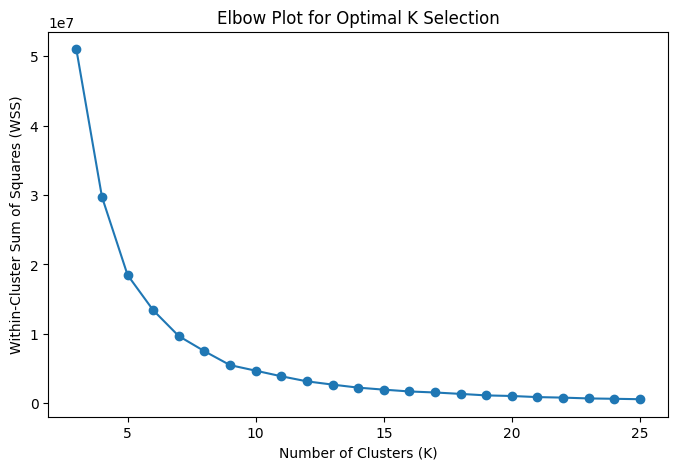

In [ ]:
# Evaluating clustering performance on varying K values
determine_optimal_k(combined_df, max_k = 25)

In [217]:
# Setting a K of 18 and placing players into relative value tiers
final_df = segment_players(combined_df, k = 18)

In [218]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

In [219]:
display(final_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank,player_value_tier
83,19755.0,Shohei Ohtani,29.0,LAD,OF,1604.961304,1737.0,1644.572900,1.0,OF,4556.627027,1.0,1.0,1
10,25764.0,Bobby Witt Jr.,24.0,KC,SS,1474.433838,1604.0,1513.303638,2.0,IF,4001.305370,2.0,1.0,2
101,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0,1557.121240,1.0,OF,3708.297913,3.0,2.0,3
48,13510.0,Jose Ramirez,31.0,CLE,3B,1462.773438,1514.0,1478.141406,3.0,IF,3607.438722,4.0,1.0,3
138,20123.0,Juan Soto,25.0,NYM,OF,1485.821655,1623.0,1526.975195,2.0,OF,3431.641936,5.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,24262.0,Ceddanne Rafaela,23.0,BOS,2B,816.478027,816.0,816.334607,97.0,IF,-1135.390586,284.0,23.0,18
80,16442.0,Ryan O'Hearn,30.0,BAL,1B,827.286743,778.0,812.500708,98.0,IF,-1148.092016,285.0,27.0,18
86,22514.0,Triston Casas,24.0,BOS,1B,644.122375,1192.0,808.485651,99.0,IF,-1161.211168,286.0,28.0,18
3,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0,IF,-1163.754818,287.0,12.0,18


In [ ]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)